# PyTorch Physics-Informed Neural Network (PINN) Example

This notebook implements the same functionality as the TensorFlow version but using PyTorch. We'll approximate the function f(x) = x² using a neural network with physics-informed constraints.

## Overview
- **Base Model**: PyTorch equivalent of PINNBaseModel
- **Zero-Order ODE**: Implementation to learn f(x) = x²
- **Training**: Custom training loop with automatic differentiation
- **Visualization**: Results comparison and convergence plots


In [25]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda


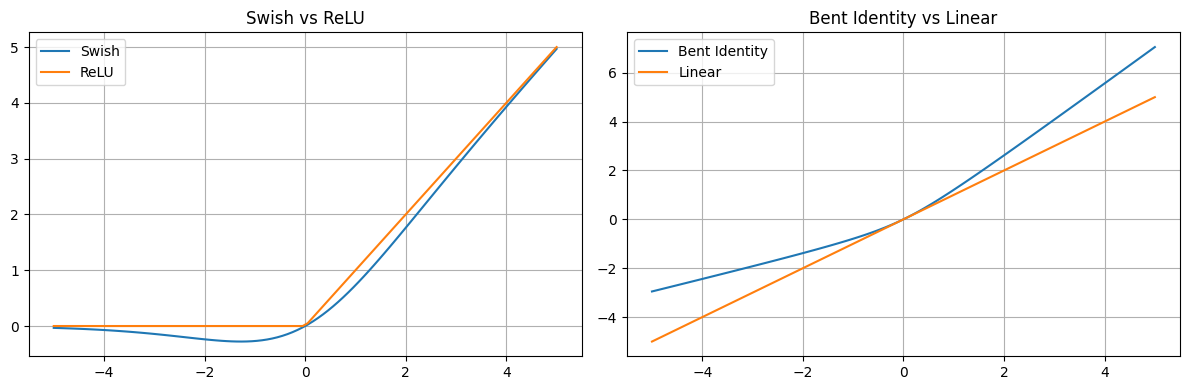

In [15]:
# Custom activation functions (equivalent to TensorFlow versions)
def swish(x):
    """Swish activation function: x * sigmoid(x)"""
    return x * torch.sigmoid(x)

def bent_identity(x):
    """Bent identity activation function to avoid saturation"""
    return x + (torch.sqrt(x*x + 1) - 1) / 2

# Test the activation functions
x_test = torch.linspace(-5, 5, 100)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_test, swish(x_test), label='Swish')
plt.plot(x_test, torch.relu(x_test), label='ReLU')
plt.title('Swish vs ReLU')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_test, bent_identity(x_test), label='Bent Identity')
plt.plot(x_test, x_test, label='Linear')
plt.title('Bent Identity vs Linear')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# PyTorch Base Model Class (equivalent to PINNBaseModel)
class PINNBaseModel(nn.Module):
    """
    Base class for Physics-Informed Neural Networks in PyTorch.
    This class handles the neural network architecture and training framework.
    """
    
    def __init__(self, 
                 in_dim=1, 
                 out_dim=1, 
                 n_hidden_layers=5, 
                 nodes_per_layer=10,
                 n_iter=1000,
                 learning_rate=0.001,
                 batch_size=1001,
                 activation='swish',
                 weight_init='he_uniform'):
        super(PINNBaseModel, self).__init__()
        
        # Store hyperparameters
        self.n_layers = n_hidden_layers
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # Create neural network layers
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(in_dim, nodes_per_layer))
        
        # Hidden layers
        for _ in range(n_hidden_layers - 1):
            self.layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        
        # Output layer
        self.layers.append(nn.Linear(nodes_per_layer, out_dim))
        
        # Set activation function
        if activation == 'swish':
            self.activation = swish
        elif activation == 'bent_identity':
            self.activation = bent_identity
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = swish  # default
        
        # Initialize weights
        self._initialize_weights(weight_init)
        
        # Set up optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        # Training history
        self.loss_history = []
        self.min_loss = float('inf')
        self.best_weights = None
        
    def _initialize_weights(self, init_type):
        """Initialize network weights"""
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if init_type == 'he_uniform':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                elif init_type == 'he_normal':
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                elif init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(layer.weight)
                elif init_type == 'xavier_normal':
                    nn.init.xavier_normal_(layer.weight)
                else:
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        """Forward pass through the network"""
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = self.activation(x)
        
        # Output layer (no activation)
        x = self.layers[-1](x)
        return x
    
    def train_step(self, x):
        """
        This method should be implemented in child classes.
        It defines the loss function and physics constraints.
        """
        raise NotImplementedError("train_step must be implemented in child class")
    
    def solve(self, train_data):
        """
        Main training loop
        """
        self.train()  # Set to training mode
        
        # Convert to PyTorch tensor if needed
        if not isinstance(train_data, torch.Tensor):
            train_data = torch.tensor(train_data, dtype=torch.float32, device=device)
        
        # Ensure model is on the correct device
        self.to(device)
        
        # Create data loader
        dataset = TensorDataset(train_data)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        print("Starting training...")
        print("=" * 50)
        
        for epoch in range(self.n_iter):
            epoch_loss = 0.0
            num_batches = 0
            
            for batch_idx, (batch_data,) in enumerate(dataloader):
                # Zero gradients
                self.optimizer.zero_grad()
                
                # Compute loss
                loss = self.train_step(batch_data)
                
                # Backward pass
                loss.backward()
                
                # Update weights
                self.optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
                
                # Print progress
                if batch_idx % 10 == 0:
                    print(f"Epoch: {epoch+1}/{self.n_iter}, "
                          f"Batch: {batch_idx+1}/{len(dataloader)}, "
                          f"Loss: {loss.item():.6e}")
            
            # Average loss for this epoch
            avg_loss = epoch_loss / num_batches
            self.loss_history.append(avg_loss)
            
            # Keep track of best weights
            if avg_loss < self.min_loss:
                self.min_loss = avg_loss
                self.best_weights = {name: param.clone() for name, param in self.named_parameters()}
        
        # Load best weights
        if self.best_weights is not None:
            for name, param in self.named_parameters():
                param.data = self.best_weights[name]
        
        print("=" * 50)
        print(f"Training completed!")
        print(f"Minimum Loss: {self.min_loss:.6e}")
        print("=" * 50)
    
    def load_model(self, filepath):
        """
        Load model with proper device handling
        """
        self.load_state_dict(torch.load(filepath, map_location=device))
        self.to(device)
        self.eval()
        print(f"Model loaded from {filepath} and moved to {device}")
    
    def save_model(self, filepath):
        """
        Save model with proper device handling
        """
        torch.save(self.state_dict(), filepath)
        print(f"Model saved to {filepath}")


In [17]:
# Zero-Order ODE Implementation (equivalent to TensorFlow version)
class ZeroOrderODE(PINNBaseModel):
    """
    Physics-Informed Neural Network to approximate f(x) = x²
    This is the PyTorch equivalent of the TensorFlow ZeroOrderODE class.
    """
    
    def __init__(self, **kwargs):
        # Set default parameters if not provided
        default_params = {
            'in_dim': 1,
            'out_dim': 1,
            'n_hidden_layers': 10,
            'nodes_per_layer': 50,
            'n_iter': 500,
            'learning_rate': 0.001,
            'batch_size': 20,
            'activation': 'swish',
            'weight_init': 'he_uniform'
        }
        
        # Update defaults with provided parameters
        default_params.update(kwargs)
        
        super(ZeroOrderODE, self).__init__(**default_params)
        
    def train_step(self, x):
        """
        Training step that defines the physics constraint.
        This is where the "magic" happens - we define the loss function
        that enforces the constraint y = x²
        """
        # Ensure x is on the correct device
        if not x.is_cuda and device.type == 'cuda':
            x = x.to(device)
        
        # Neural network prediction
        y_hat = self.forward(x)
        
        # Physics constraint: y = x²
        # Loss function: MSE between prediction and true function
        target = x**2
        loss = torch.mean((y_hat - target)**2)
        
        return loss


In [18]:
# Create and configure the model (equivalent to TensorFlow version)
model = ZeroOrderODE(
    in_dim=1,
    out_dim=1,
    n_hidden_layers=10,
    nodes_per_layer=50,
    n_iter=500,
    learning_rate=0.001,
    batch_size=20,
    activation='swish',
    weight_init='he_uniform'
)

# Move model to device
model = model.to(device)

print("Model created successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


Model created successfully!
Model device: cuda:0
Number of parameters: 23101


Training set shape: torch.Size([20, 1])
Training range: [-20, 20]
Number of training points: 20


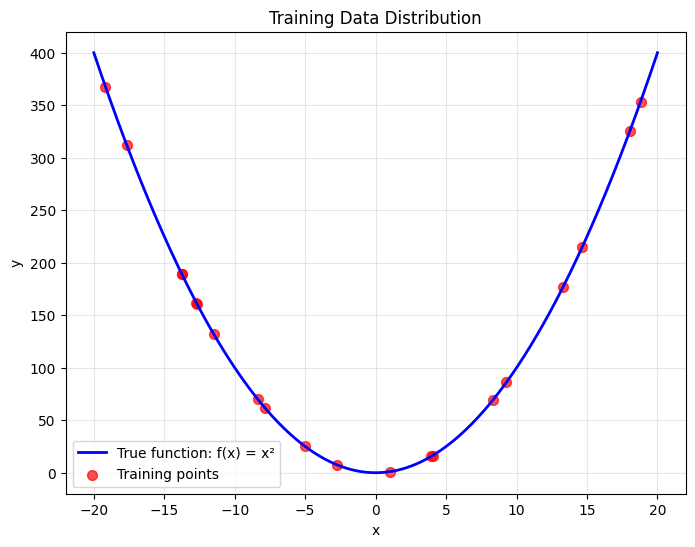

In [19]:
# Generate training data (equivalent to TensorFlow version)
train_min = -20
train_max = 20
n_train = 20
scale = train_max - train_min

# Create training set
train_set = train_min + scale * np.random.rand(n_train, 1)
train_set = torch.tensor(train_set, dtype=torch.float32, device=device)

print(f"Training set shape: {train_set.shape}")
print(f"Training range: [{train_min}, {train_max}]")
print(f"Number of training points: {n_train}")

# Visualize training data
plt.figure(figsize=(8, 6))
x_plot = np.linspace(train_min, train_max, 1000)
y_true = x_plot**2

plt.plot(x_plot, y_true, 'b-', label='True function: f(x) = x²', linewidth=2)
plt.scatter(train_set.cpu().numpy(), train_set.cpu().numpy()**2, 
           color='red', s=50, alpha=0.7, label='Training points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [20]:
# Train the model
print("Starting training...")
model.solve(train_set)


Starting training...
Starting training...
Epoch: 1/500, Batch: 1/1, Loss: 3.009628e+04
Epoch: 2/500, Batch: 1/1, Loss: 2.599201e+04
Epoch: 3/500, Batch: 1/1, Loss: 2.170614e+04


Epoch: 4/500, Batch: 1/1, Loss: 1.736585e+04
Epoch: 5/500, Batch: 1/1, Loss: 1.290553e+04
Epoch: 6/500, Batch: 1/1, Loss: 9.066315e+03
Epoch: 7/500, Batch: 1/1, Loss: 5.920269e+03
Epoch: 8/500, Batch: 1/1, Loss: 3.728482e+03
Epoch: 9/500, Batch: 1/1, Loss: 2.982547e+03
Epoch: 10/500, Batch: 1/1, Loss: 3.704622e+03
Epoch: 11/500, Batch: 1/1, Loss: 4.943979e+03
Epoch: 12/500, Batch: 1/1, Loss: 5.438879e+03
Epoch: 13/500, Batch: 1/1, Loss: 4.917724e+03
Epoch: 14/500, Batch: 1/1, Loss: 3.936720e+03
Epoch: 15/500, Batch: 1/1, Loss: 2.913058e+03
Epoch: 16/500, Batch: 1/1, Loss: 2.241523e+03
Epoch: 17/500, Batch: 1/1, Loss: 1.993651e+03
Epoch: 18/500, Batch: 1/1, Loss: 2.084716e+03
Epoch: 19/500, Batch: 1/1, Loss: 2.367310e+03
Epoch: 20/500, Batch: 1/1, Loss: 2.645148e+03
Epoch: 21/500, Batch: 1/1, Loss: 2.766474e+03
Epoch: 22/500, Batch: 1/1, Loss: 2.702376e+03
Epoch: 23/500, Batch: 1/1, Loss: 2.513815e+03
Epoch: 24/500, Batch: 1/1, Loss: 2.279681e+03
Epoch: 25/500, Batch: 1/1, Loss: 2.09007

In [21]:
# Generate test data and evaluate the model
n_test = 50
test_set = train_min + scale * np.random.rand(n_test, 1)
test_set_tensor = torch.tensor(test_set, dtype=torch.float32, device=device)

# Get predictions
model.eval()  # Set to evaluation mode
with torch.no_grad():
    predictions = model(test_set_tensor)

# Convert to numpy for plotting
x_test = test_set[:, 0]
y_pred = predictions.cpu().numpy().flatten()
y_true = x_test**2

print(f"Test set size: {n_test}")
print(f"Prediction shape: {predictions.shape}")


Test set size: 50
Prediction shape: torch.Size([50, 1])


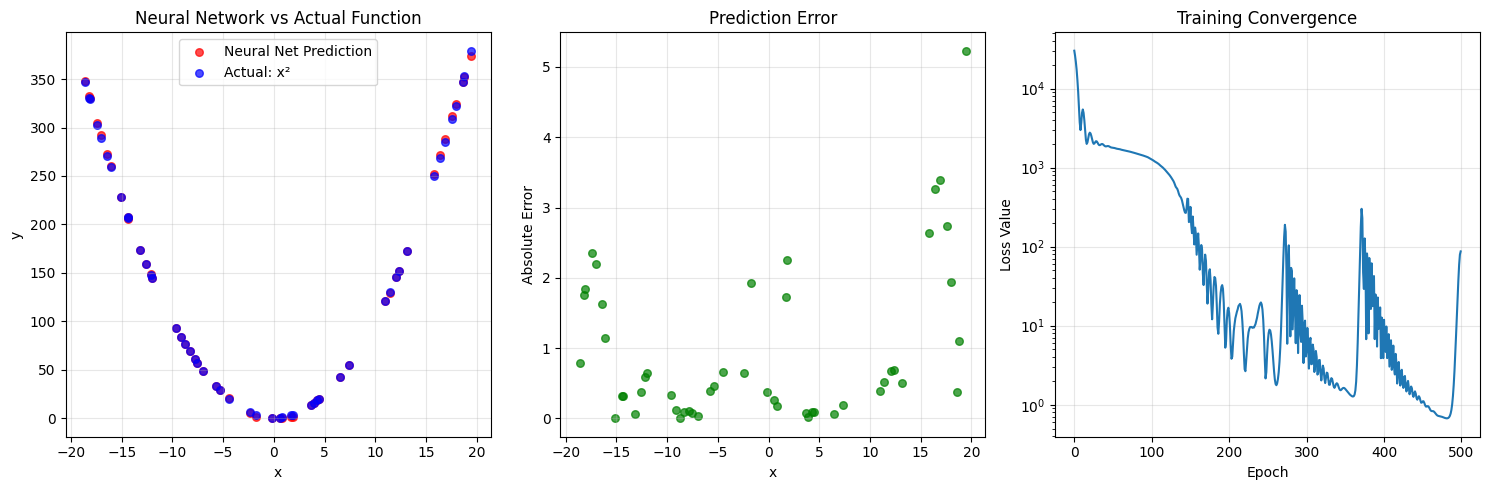


Model Performance Metrics:
Mean Squared Error (MSE): 2.134596e+00
Mean Absolute Error (MAE): 9.544248e-01
Maximum Error: 5.230593e+00
Final Training Loss: 8.705220e+01


In [22]:
# Visualization: Comparison with actual function
plt.figure(figsize=(15, 5))

# Plot 1: Predictions vs Actual
plt.subplot(1, 3, 1)
plt.scatter(x_test, y_pred, color='red', alpha=0.7, s=30, label='Neural Net Prediction')
plt.scatter(x_test, y_true, color='blue', alpha=0.7, s=30, label='Actual: x²')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network vs Actual Function')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error analysis
plt.subplot(1, 3, 2)
error = np.abs(y_pred - y_true)
plt.scatter(x_test, error, color='green', alpha=0.7, s=30)
plt.xlabel('x')
plt.ylabel('Absolute Error')
plt.title('Prediction Error')
plt.grid(True, alpha=0.3)

# Plot 3: Convergence history
plt.subplot(1, 3, 3)
plt.plot(model.loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Training Convergence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display metrics
mse = np.mean((y_pred - y_true)**2)
mae = np.mean(np.abs(y_pred - y_true))
max_error = np.max(np.abs(y_pred - y_true))

print(f"\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6e}")
print(f"Mean Absolute Error (MAE): {mae:.6e}")
print(f"Maximum Error: {max_error:.6e}")
print(f"Final Training Loss: {model.loss_history[-1]:.6e}")


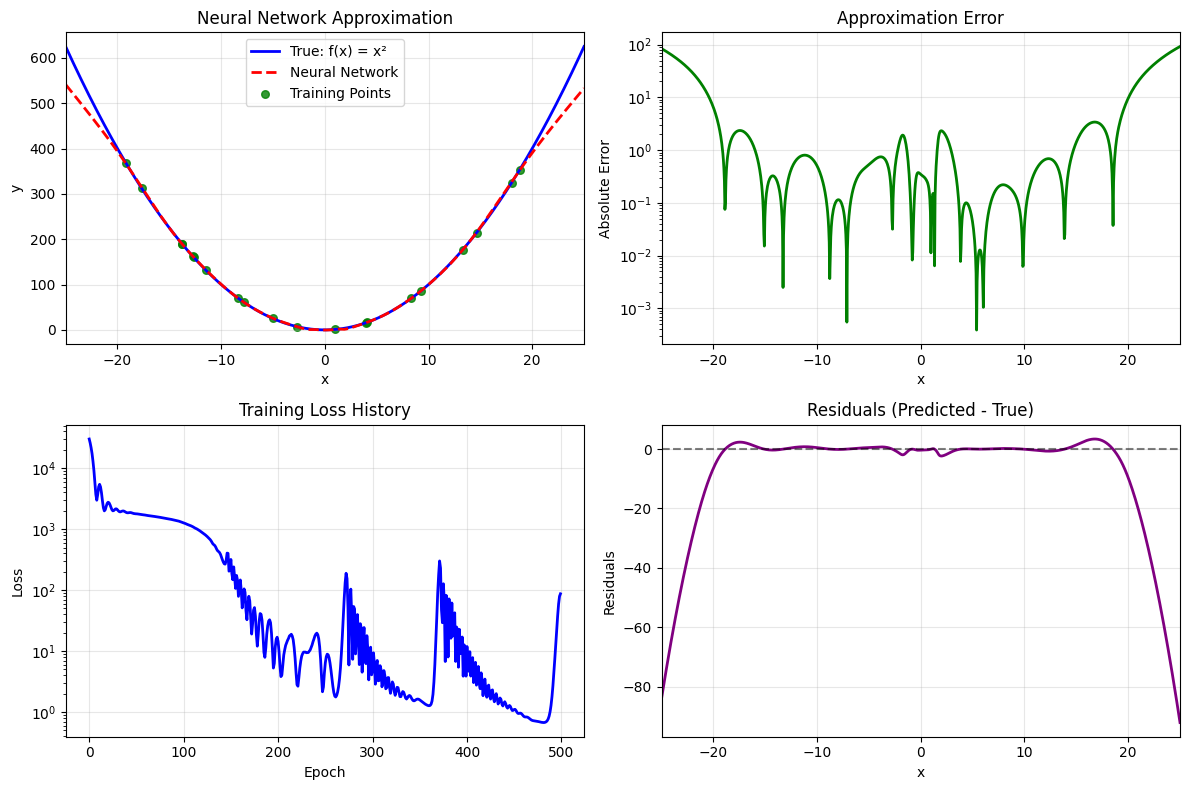

Detailed Analysis:
Range analyzed: [-25, 25]
Maximum error in range: 9.209418e+01
Mean error in range: 9.261121e+00


In [23]:
# Detailed analysis: Plot the learned function over a wider range
x_detailed = np.linspace(-25, 25, 1000)
x_detailed_tensor = torch.tensor(x_detailed.reshape(-1, 1), dtype=torch.float32, device=device)

model.eval()
with torch.no_grad():
    y_detailed_pred = model(x_detailed_tensor).cpu().numpy().flatten()

y_detailed_true = x_detailed**2

plt.figure(figsize=(12, 8))

# Main comparison plot
plt.subplot(2, 2, 1)
plt.plot(x_detailed, y_detailed_true, 'b-', linewidth=2, label='True: f(x) = x²')
plt.plot(x_detailed, y_detailed_pred, 'r--', linewidth=2, label='Neural Network')
plt.scatter(train_set.cpu().numpy(), train_set.cpu().numpy()**2, 
           color='green', s=30, alpha=0.8, label='Training Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Approximation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-25, 25)

# Error plot
plt.subplot(2, 2, 2)
error_detailed = np.abs(y_detailed_pred - y_detailed_true)
plt.plot(x_detailed, error_detailed, 'g-', linewidth=2)
plt.xlabel('x')
plt.ylabel('Absolute Error')
plt.title('Approximation Error')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.xlim(-25, 25)

# Training loss history
plt.subplot(2, 2, 3)
plt.plot(model.loss_history, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Residuals plot
plt.subplot(2, 2, 4)
residuals = y_detailed_pred - y_detailed_true
plt.plot(x_detailed, residuals, 'purple', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('x')
plt.ylabel('Residuals')
plt.title('Residuals (Predicted - True)')
plt.grid(True, alpha=0.3)
plt.xlim(-25, 25)

plt.tight_layout()
plt.show()

print(f"Detailed Analysis:")
print(f"Range analyzed: [-25, 25]")
print(f"Maximum error in range: {np.max(error_detailed):.6e}")
print(f"Mean error in range: {np.mean(error_detailed):.6e}")


In [24]:
# Comparison with TensorFlow implementation
print("=" * 60)
print("PYTORCH vs TENSORFLOW COMPARISON")
print("=" * 60)
print(f"Framework: PyTorch {torch.__version__}")
print(f"Device: {device}")
print(f"Model Architecture: {model.n_layers} hidden layers, {model.layers[0].out_features} nodes each")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Training Epochs: {model.n_iter}")
print(f"Learning Rate: {model.learning_rate}")
print(f"Batch Size: {model.batch_size}")
print(f"Activation Function: Swish")
print(f"Final Loss: {model.loss_history[-1]:.6e}")
print("=" * 60)

# Add the missing methods to the model if they don't exist
if not hasattr(model, 'save_model'):
    def save_model(self, filepath):
        """Save model with proper device handling"""
        torch.save(self.state_dict(), filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load model with proper device handling"""
        self.load_state_dict(torch.load(filepath, map_location=device))
        self.to(device)
        self.eval()
        print(f"Model loaded from {filepath} and moved to {device}")
    
    # Add methods to the model instance
    model.save_model = save_model.__get__(model, model.__class__)
    model.load_model = load_model.__get__(model, model.__class__)

# Save the model using the new method
model.save_model('pytorch_pinn_model.pth')

# Demonstrate model loading using the new method
print("\nDemonstrating model loading...")
loaded_model = ZeroOrderODE()

# Add the methods to the loaded model as well
if not hasattr(loaded_model, 'load_model'):
    def load_model(self, filepath):
        """Load model with proper device handling"""
        self.load_state_dict(torch.load(filepath, map_location=device))
        self.to(device)
        self.eval()
        print(f"Model loaded from {filepath} and moved to {device}")
    
    loaded_model.load_model = load_model.__get__(loaded_model, loaded_model.__class__)

loaded_model.load_model('pytorch_pinn_model.pth')

# Test loaded model
test_x = torch.tensor([[5.0]], dtype=torch.float32, device=device)
with torch.no_grad():
    prediction = loaded_model(test_x)
    true_value = test_x**2

print(f"Test input: {test_x.item()}")
print(f"Predicted output: {prediction.item():.6f}")
print(f"True output: {true_value.item():.6f}")
print(f"Error: {abs(prediction.item() - true_value.item()):.6f}")


PYTORCH vs TENSORFLOW COMPARISON
Framework: PyTorch 2.8.0+cu128
Device: cuda
Model Architecture: 10 hidden layers, 50 nodes each
Total Parameters: 23101
Training Epochs: 500
Learning Rate: 0.001
Batch Size: 20
Activation Function: Swish
Final Loss: 8.705220e+01
Model saved to pytorch_pinn_model.pth

Demonstrating model loading...
Model loaded from pytorch_pinn_model.pth and moved to cuda
Test input: 5.0
Predicted output: 25.042221
True output: 25.000000
Error: 0.042221


## Key Differences: PyTorch vs TensorFlow Implementation

### 1. **Automatic Differentiation**
- **TensorFlow**: Uses `tf.GradientTape()` to record operations and compute gradients
- **PyTorch**: Uses `torch.autograd` with automatic gradient computation during forward pass

### 2. **Model Definition**
- **TensorFlow**: Uses `tf.keras.Sequential()` for model creation
- **PyTorch**: Inherits from `nn.Module` and defines `forward()` method

### 3. **Training Loop**
- **TensorFlow**: Uses `@tf.function` decorator for graph compilation
- **PyTorch**: Uses standard Python loops with `model.train()` and `model.eval()`

### 4. **Device Management**
- **TensorFlow**: Automatic device placement
- **PyTorch**: Explicit device management with `.to(device)`

### 5. **Data Handling**
- **TensorFlow**: Uses `tf.constant()` and TensorFlow datasets
- **PyTorch**: Uses `torch.tensor()` and `DataLoader` for batching

### 6. **Loss Computation**
- **TensorFlow**: `tf.reduce_sum()` and `tf.reduce_mean()`
- **PyTorch**: `torch.sum()` and `torch.mean()`

## Advantages of PyTorch Implementation

1. **More Pythonic**: Easier to debug and understand
2. **Dynamic Graphs**: More flexible for complex architectures
3. **Better Integration**: Seamless integration with NumPy and Python
4. **Easier Debugging**: Can use standard Python debugging tools
5. **More Control**: Fine-grained control over training process
